In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# function to load the data files with the model and the betting vendor precitions for the last season
def load_data(file1, file2):
    model_data = pd.read_csv('match_data_bl_wo_nan_s_2022.csv') # loading of the dataset with the model predcitions
    betting_odds_data = pd.read_csv('dataframe_with_odd_predictions_v2.csv') # loading of the dataset with the odd predictions
    return model_data, betting_odds_data

In [34]:
# function to translate the game results into numerical values
def convert_ftr(result: str):
    if result == "D":
        return 1
    elif result == "H":
        return 2
    elif result == "A":
        return 0
    else:
        return None

In [35]:
# function to only select the columns necessary for the comparison of our model and the betting vendors
# calling functions to harmonize the dataframes
def reduce_data(model_data, betting_odds_data):
    model_data_reduced = model_data[[
        'FTR', 'predictedResults', 'ProbAwayWin', 'ProbDraw', 'ProbHomeWin'
    ]]
    betting_odds_data_reduced = betting_odds_data[[
        'Betting_Prediction', 'Betting_Prediction_Probability'
    ]]
    betting_odds_data_reduced[
        'Betting_Prediction'] = betting_odds_data_reduced[
            'Betting_Prediction'].apply(convert_ftr) # translation of the game results into numerical values
    betting_odds_data_reduced = betting_odds_data_reduced[-216:].reset_index() # only selecting the games from the last season
    return model_data_reduced, betting_odds_data_reduced

In [36]:
# function to get the probabilities for the result predicted from the model
def get_model_prediction_probability(model_data_reduced):
    result_probability = []
    z = 0
    while z < len(model_data_reduced): # loop to get the probability for the predicted result
        if model_data_reduced['predictedResults'][z] == 0:
            result_probability.append(model_data_reduced['ProbAwayWin'][z])
        if model_data_reduced['predictedResults'][z] == 1:
            result_probability.append(model_data_reduced['ProbDraw'][z])
        if model_data_reduced['predictedResults'][z] == 2:
            result_probability.append(model_data_reduced['ProbHomeWin'][z])
        z += 1
    return result_probability

In [37]:
def get_odd_prediction(data_model_reduced):
    erg_prob = []
    z = 0
    while z < len(data_model_reduced
                  ):  # loop to get the probability for the predicted result
        if data_model_reduced['predictedResults'][z] == 0:
            erg_prob.append(data_model_reduced['ProbAwayWin'][z])
        if data_model_reduced['predictedResults'][z] == 1:
            erg_prob.append(data_model_reduced['ProbDraw'][z])
        if data_model_reduced['predictedResults'][z] == 2:
            erg_prob.append(data_model_reduced['ProbHomeWin'][z])
        z += 1
    return erg_prob

In [38]:
# function to add the probabilities for the result predicted from the model to the dataframe
def add_model_probabilities(model_data_reduced):
    model_prediction_probability = get_odd_prediction(model_data_reduced)
    model_data_reduced[
        'Model_Prediction_Probability'] = model_prediction_probability # adding the probabilities for the predicted results to the dataframe
    return model_data_reduced

In [39]:
# function to merge the dataframes from the model and the betting odds
def merge_dataframes(model_data_reduced, betting_odds_data_reduced):
    data_for_evaluation = model_data_reduced[[
        'FTR', 'predictedResults', 'Model_Prediction_Probability'
    ]].merge(betting_odds_data_reduced[[
        'Betting_Prediction', 'Betting_Prediction_Probability'
    ]],
             how='inner',
             left_index=True,
             right_index=True) # merging of the dataframes
    return data_for_evaluation

In [40]:
# function the get the number of the right picks from model, odds and only home team predictions
def get_evaluation_score(data_for_evaluation):
    right_model, right_odds, right_home = 0, 0, 0
    right_model_list, right_odds_list, right_home_list = [], [], []
    z = 0
    while z < len(data_for_evaluation):
        if data_for_evaluation['FTR'][z] == data_for_evaluation[
                'predictedResults'][z]:
            right_model += 1
        if data_for_evaluation['FTR'][z] == data_for_evaluation[
                'Betting_Prediction'][z]:
            right_odds += 1
        if data_for_evaluation['FTR'][z] == 2:
            right_home += 1
        right_model_list.append(right_model)
        right_odds_list.append(right_odds)
        right_home_list.append(right_home)
        z += 1

    return right_model, right_odds, right_home, right_model_list, right_odds_list, right_home_list

In [41]:
# function to print the accuracy for model, betting odds and only home team predictions
def print_accuracys(right_model, right_odds, right_home, data_for_evaluation):
    print('Accuracy Model: ', right_model / len(data_for_evaluation))
    print('Accuracy Odds: ', right_odds / len(data_for_evaluation))
    print('Accuracy Home: ', right_home / len(data_for_evaluation))

In [42]:
#  function to plot the number of the right picks over the last season
def show_right_picks(right_model_list, right_odds_list, right_home_list):
    x = np.linspace(0, 216, 216)

    y1 = right_model_list
    y2 = right_odds_list
    y3 = right_home_list

    plt.figure(num=3, figsize=(25, 12.5))
    plt.plot(x, y1, color='blue', linewidth=3.0, label='Model')
    plt.plot(x, y2, color='red', linewidth=3.0, label='Odds')
    plt.plot(x, y3, color='green', linewidth=3.0, label='Home')

    plt.xlabel("Number of Games")
    plt.ylabel("Right Predictions")

    plt.legend()
    plt.show()

In [43]:
# function to transfer the result probabilities into betting odds
def probability_to_odds(data_for_evaluation):
    z, model_odds, betting_odds = 0, 0, 0
    model_odds_list, betting_odds_list = [], []
    while z < len(data_for_evaluation):
        model_odds = 1 / (
            (data_for_evaluation['Model_Prediction_Probability'][z] * 100) /
            100)
        model_odds_list.append(model_odds)

        betting_odds = 1 / (
            (data_for_evaluation['Betting_Prediction_Probability'][z]) / 100)
        betting_odds_list.append(betting_odds)
        z += 1
    data_for_evaluation['Model_Odds'] = model_odds_list
    data_for_evaluation['Betting_Odds'] = betting_odds_list

In [44]:
# function to simulate betting with the model predcitions
def betting_with_the_model(data_for_evaluation):
    z, model_bank = 0, 1000
    bank_model_list = []
    while z < len(data_for_evaluation):
        if data_for_evaluation['Model_Prediction_Probability'][z] * 100 <= 40:
            model_bank = model_bank
            if data_for_evaluation['predictedResults'][
                    z] == data_for_evaluation['FTR'][z]:
                model_bank = model_bank
                # model_bank = model_bank + 2 * data_evaluation['Model_Odds'][z]
        elif data_for_evaluation['Model_Prediction_Probability'][z] * 100 <= 70:
            model_bank = model_bank
            if data_for_evaluation['predictedResults'][
                    z] == data_for_evaluation['FTR'][z]:
                model_bank = model_bank
                # model_bank = model_bank + 5 * data_evaluation['Model_Odds'][z]
        elif data_for_evaluation['Model_Prediction_Probability'][z] * 100 <= 80:
            model_bank = model_bank - 7
            if data_for_evaluation['predictedResults'][
                    z] == data_for_evaluation['FTR'][z]:
                model_bank = model_bank + 7 * data_for_evaluation[
                    'Model_Odds'][z]
        elif data_for_evaluation['Model_Prediction_Probability'][z] * 100 > 80:
            model_bank = model_bank - 10
            if data_for_evaluation['predictedResults'][
                    z] == data_for_evaluation['FTR'][z]:
                model_bank = model_bank + 10 * data_for_evaluation[
                    'Model_Odds'][z]
        else:
            print('Fehler!')
        bank_model_list.append(model_bank)
        z += 1
    return bank_model_list

In [45]:
# function to simulate betting with the betting odd predcitions
def betting_with_the_odds(data_for_evaluation):
    z, odds_bank = 0, 1000
    bank_odds_list = []
    while z < len(data_for_evaluation):
        if data_for_evaluation['Betting_Prediction_Probability'][z] * 100 <= 40:
            odds_bank = odds_bank
            if data_for_evaluation['Betting_Prediction'][
                    z] == data_for_evaluation['FTR'][z]:
                odds_bank = odds_bank
                # odds_bank = odds_bank + 2 * data_evaluation['Betting_Odds'][z]
        elif data_for_evaluation['Betting_Prediction_Probability'][
                z] * 100 <= 70:
            odds_bank = odds_bank
            if data_for_evaluation['Betting_Prediction'][
                    z] == data_for_evaluation['FTR'][z]:
                odds_bank = odds_bank
                # odds_bank = odds_bank + 5 * data_evaluation['Betting_Odds'][z]
        elif data_for_evaluation['Betting_Prediction_Probability'][
                z] * 100 <= 80:
            odds_bank = odds_bank - 7
            if data_for_evaluation['Betting_Prediction'][
                    z] == data_for_evaluation['FTR'][z]:
                odds_bank = odds_bank + 7 * data_for_evaluation[
                    'Betting_Odds'][z]
        elif data_for_evaluation['Betting_Prediction_Probability'][
                z] * 100 > 80:
            odds_bank = odds_bank - 10
            if data_for_evaluation['Betting_Prediction'][
                    z] == data_for_evaluation['FTR'][z]:
                odds_bank = odds_bank + 10 * data_for_evaluation[
                    'Betting_Odds'][z]
        else:
            print('Fehler!')
        bank_odds_list.append(odds_bank)
        z += 1
    return bank_odds_list

In [46]:
# function to show the bank balance while the betting simulations
def simulate_betting_profit(bank_odds_list, bank_model_list):
    x = np.linspace(0, 216, 216)
    y = np.linspace(1000, 1000, 216)
    y1 = bank_odds_list
    y2 = bank_model_list

    plt.figure(num=3, figsize=(25, 12.5))
    plt.plot(x, y1, color='red', linewidth=3.0, label='Odds')
    plt.plot(x, y2, color='blue', linewidth=3.0, label='Model')
    plt.plot(x,
             y,
             color='black',
             linewidth=3.0,
             label='Baseline',
             linestyle='--')

    plt.xlabel("Number of Games")
    plt.ylabel("Money")

    plt.legend()
    plt.show()

In [47]:
# function to get the accuracy and the plots with one click
def run_all(file1, file2):
    model_data, betting_odds_data = load_data(file1, file2)
    model_data_reduced, betting_odds_data_reduced = reduce_data(
        model_data, betting_odds_data)
    # result_probability = get_model_prediction_probability(model_data_reduced)
    model_data_reduced = add_model_probabilities(model_data_reduced)
    data_for_evaluation = merge_dataframes(model_data_reduced,
                                           betting_odds_data_reduced)
    right_model, right_odds, right_home, right_model_list, right_odds_list, right_home_list = get_evaluation_score(
        data_for_evaluation)
    print_accuracys(right_model, right_odds, right_home, data_for_evaluation)
    show_right_picks(right_model_list, right_odds_list, right_home_list)
    probability_to_odds(data_for_evaluation)
    bank_model_list = betting_with_the_model(data_for_evaluation)
    bank_odds_list = betting_with_the_odds(data_for_evaluation)
    simulate_betting_profit(bank_odds_list, bank_model_list)


C:\Users\I539022\AppData\Local\Temp/ipykernel_35564/2606276871.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_odds_data_reduced[
C:\Users\I539022\AppData\Local\Temp/ipykernel_35564/1111329387.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_reduced[


Accuracy Model:  0.4722222222222222
Accuracy Odds:  0.5046296296296297
Accuracy Home:  0.4583333333333333


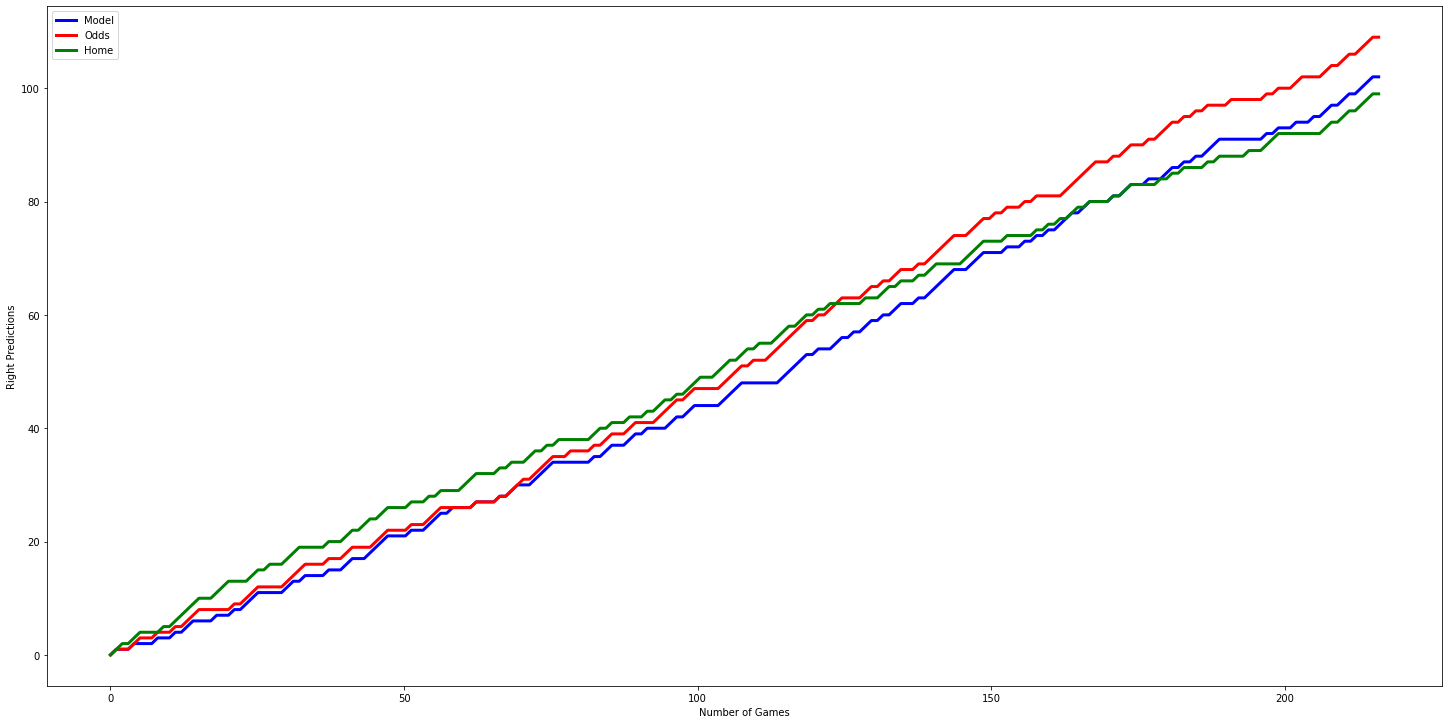

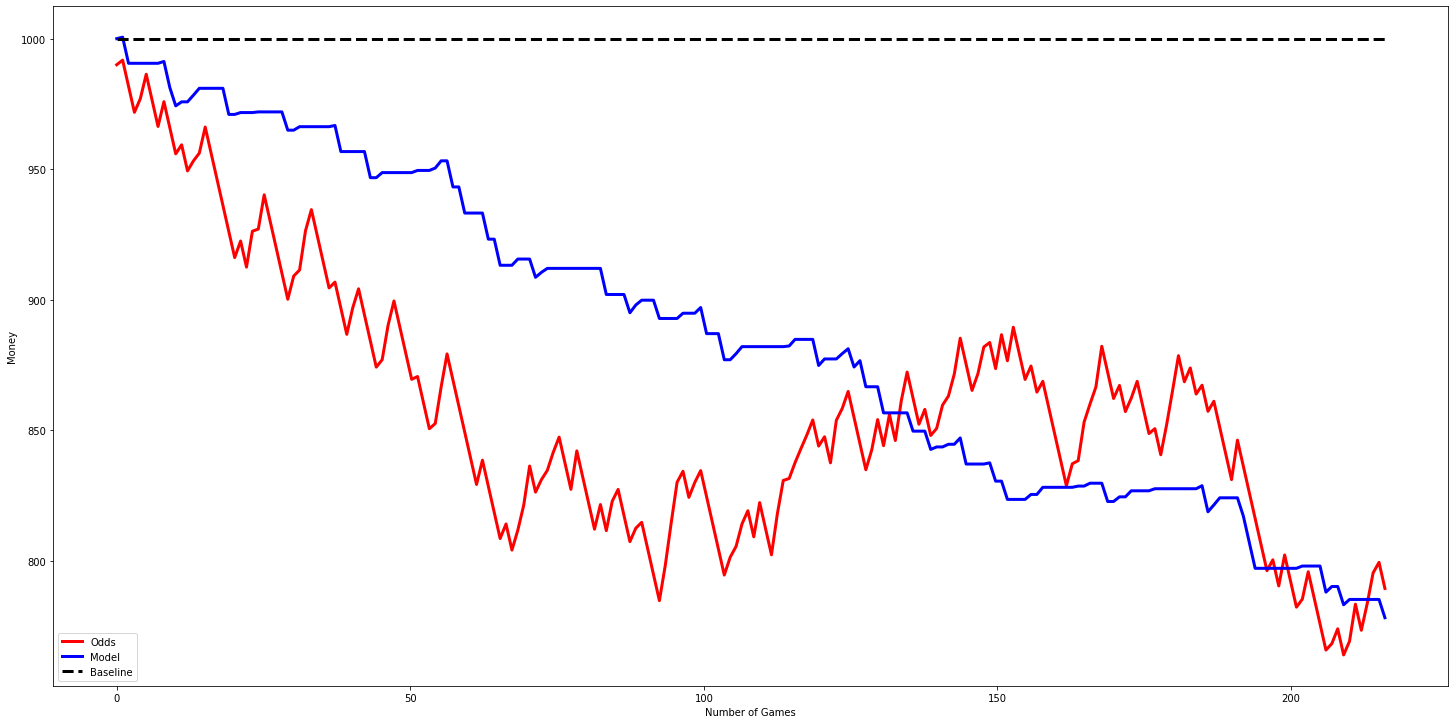

In [48]:
file1 = 'match_data_bl_wo_nan_s_2022.csv'
file2 = 'dataframe_with_odd_predictions_v2.csv'
run_all(file1, file2)